# Notebook for quality control of MEG data

Authors: Lucas Breedt & Mona Zimmerman

This notebook is meant to help in checking MEG data.  
Note that pre-processing of the data is not included in this notebook -- it assumes data have already been processed

## Table of contents
1. [Imports](#imports)
2. [Load data](#load-data)
3. [Checking the data - I](#data-check-1)  
    a. [Visual inspection of the epochs](#visual-inspection)  
    b. [The power spectrum](#power-spectrum)  
4. [Fast Fourier transform & the phase lag index](#fft-pli)
5. [Checking the data - II](#data-check-2)  
    a. [Adjacency matrices](#adjacency-matrix)  
    b. [Check for weird/empty signals](#check-signal)  
    c. [The occipital network](#occ-network)  
    ---> is there a list of BNA regions belonging to Yeo's visual network?

<a id='imports'></a>
## **1.** Imports
#### Let's first import all the necessary packages...

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Signal processing libraries
from scipy import signal
from scipy.fft import fft, irfft2, ifft2, irfftn, irfft, ifft
from scipy.fftpack import hilbert

# Set seaborn style for plot syling
sns.set()

<a id='load-data'></a>
## **2.** Load data
#### ...and load the MEG data.

In [2]:
# Loading a single ascii of one subject
file = pd.read_csv('./meg_data/OD1_Tr01.asc', delimiter='\t', header=None, index_col=False)

In [ ]:
# Load all asciis
### --- I guess for one sub for now - would be nice to write some sort of loop/function to do it for all
### --- subs in a folder 

##### The shape of the file should be the number of samples in your epoch x the number of regions; so let's do a quick check just to make sure:

In [117]:
file.shape

(16384, 246)

In [245]:
# Convert the data from a dataframe to a numpy array for future operations
file_np = file.to_numpy()

<a id='data-check-1'></a>
## **3.** Checking the data - I
<a id='visual-inspection'></a>
### a. Visual inspection of the epochs
As a quick visual check of your data, we'll now plot the first 3 seconds of data of every 10th region of one epoch; this should give you a global overview of the data.

##### You'll have to set some variables first; change these to fit your needs.

In [407]:
fs = 1250 # sample size; so this is the amount of samples per second
stp = 3 # seconds to plot; indicate how many seconds of data you want to plot
start = 0 # start-time of plot in seconds; indicate where you want plot to start (default = 0 for first stp s)
regions = 210 # number of regions you wish to use

Next we'll create some more variables to get the information needed to create the right plot: time_stp will ...; and file_stp will be a subset of the full epoch with as many seconds of data as you wish to plot.

In [408]:
ns = file.shape[0] # total number of samples per epoch
time = np.linspace(0, ns/fs, ns) # time in seconds per sample
time_stp = time[fs*start:(fs*start + (fs*stp -1))] # this will be the x-axis of the plot, indicating the time in seconds
file_stp = file_np[fs*start:(fs*start + (fs*stp -1))] # this is a subset of the epoch, containing stp seconds of data

##### And, finally, here is the plot, displaying a couple seconds of the timeseries of every 10th region of the epoch:

In [434]:
### --- should regions be a list? so people can decide which regions they want to include? and then maybe
### --- we can add a parameter to choose between every nth channel or exact specified channels
def plot_timeseries(file_np, fs=1250, stp=3, start=0, regions=210):
    """ Plot several seconds of data from multiple channels of timeseries data
    
    Parameters
    ----------
    file_np: ndarray
        Rows are timepoints, columns are rois/electrodes
    fs: int, optional
        Sample frequency, default=1250
    stp: int, optional
        Amount of seconds of data to be plotted, default=3 seconds
    start: int, optional
        Starting point of plot, default=0 (ie beginning of timeseries)
    regions: int, optional
        Number of regions you wish to use
        
    Returns
    -------
    plot?
        
    Notes
    -----
    Code used in this function was adapted from https://plotly.com/python/v3/ipython-notebooks/mne-tutorial/

    """

    ns = file.shape[0] # total number of samples per epoch
    time = np.linspace(0, ns/fs, ns) # time in seconds per sample
    time_stp = time[fs*start:(fs*start + (fs*stp -1))] # this will be the x-axis of the plot, indicating the time in seconds
    file_stp = file_np[fs*start:(fs*start + (fs*stp -1))] # this is a subset of the epoch, containing stp seconds of data
    
    channels = np.arange(9, regions, step=10)
    n_channels = len(channels)
    
    step = 1. / n_channels
    kwargs = dict(domain=[1 - step, 1], showticklabels=False, zeroline=False, showgrid=False)
    
    # create objects for layout and traces
    layout = go.Layout(yaxis=YAxis(kwargs), showlegend=False)
    traces = [Scatter(x=time_stp, y=file_stp[:, 0])]
    
    # loop over the channels
    for ii in range(1, n_channels):
            kwargs.update(domain=[1 - (ii + 1) * step, 1 - ii * step])
            layout.update({'yaxis%d' % (ii + 1): YAxis(kwargs), 'showlegend': False})
            traces.append(Scatter(x=time_stp, y=file_stp[:, channels[ii]], yaxis='y%d' % (ii + 1)))
    
    # add channel names using Annotations
    annotations = Annotations([go.layout.Annotation(x=-0.06, y=0, xref='paper', yref='y%d' % (ii + 1), 
                                                    text='ROI ' + str(channels[ii] + 1), showarrow=False)
                              for ii in range(0, n_channels)])
    layout.update(annotations=annotations)
    
    # set the size of the figure and plot it
    layout.update(autosize=False, width=1000, height=800, 
                  title={'text':'<b>Time: '+str(start)+'s - '+str(start+stp)+'s</b>',
                         'y':0.9,
                         'x':0.5,
                        'yanchor':'top',
                        'xanchor':'center'},
                  xaxis=dict(showticklabels=False, tickmode='array', tickvals=np.arange(start+1, start+stp+1, 1)))
    #x_values = list(range(1,11))
    #xaxes_dict = [dict(x=x_val, y=-0.5, xref='x', yref='y10', text=str(x_val), 
    #                   showarrow=False) for x_val in x_values]
    #xaxis_title = [dict(x=2.6, y=-0.5, xref='x', yref='y10', text="Time (s)", showarrow=False)]
    #axes_dict = xaxes_dict + xaxis_title + yaxes_dict 
    #layout.update(annotations=axes_dict)
    fig = Figure(data=Data(traces), layout=layout)
    
    return go.Figure(fig)
    
    

In [510]:
fs = 1250 # sample size; so this is the amount of samples per second
stp = 3 # seconds to plot; indicate how many seconds of data you want to plot
start = 0 # start-time of plot in seconds; indicate where you want plot to start (default = 0 for first stp s)
regions = 210 # number of regions you wish to use

In [511]:
plot_timeseries(file_np, stp=stp, start=start, fs=fs, regions=regions)

<a id='power-spectrum'></a>
### **b.** The power spectrum
Now we'll calculate and plot the power spectrum. Also, to ensure a dominant alpha rhythm is present occipitally, we will look at occipital versus non-occipital power spectra.

In [276]:
# First we define a function to calculate and plot the power spectrum -- this is taken from Tianne's scripts
# and slightly modified
### --- don't know if this is the best way to do it, maybe import from somewhere else?
### !NOTE! added option to save powerspectrum; if set to True it returns f and pxx, otherwise it doesn't
def cal_power_spectrum (timeseries, nr_rois=np.arange(210), fs=1250, 
            window='hamming', nperseg=4096, scaling='spectrum', 
            plot_figure=False, title_plot='average power spectrum', save_powspec=True):

    """ Calculate (and plot) power spectrum of timeseries
    
    Parameters
    ----------
    timeseries: DataFrame with ndarrays
        Rows are timepoints, columns are rois/electrodes
    nr_rois: int, optional
        Give list with rois/electrodes you want to include, 
        default=np.arange(210)
    fs: int, optional    
        Sample frequency, default=1250    
    window: str or tuple, optional
        Type of window you want to use, check spectral.py for details, 
        default='hamming'
    nperseg : int, optional    
        Length of each segment, default=4096
    scaling : str, optional
        'density' calculates the power spectral density (V**2/Hz), 'spectrum' 
        calculates the power spectrum (V**2), default='spectrum'
    plot_figure: bool, optional
        Creates a figure of the mean + std over all rois/electrodes, 
        default=False
    title_plot: str, optional
        Give title of the plot, default='average power spectrum'
    save_powspec: bool, optional
        If False, f and pxx are not returned (if only plot is required),
        default=True
        
    Returns
    -------
    f: ndarray
        Array with sample frequencies (x-asix of power spectrum plot)
    pxx: ndarray
        Columns of power spectra for each roi/VE
            
    """
  
    pxx = np.empty([int(nperseg/2+1), np.size(nr_rois)])
    
    i=0
    for roi in nr_rois:
        (f, pxx[:,i]) = signal.welch(timeseries[roi].values, fs, window, 
                                     nperseg, scaling=scaling)
        i=i+1
    if plot_figure==True:
        plt.figure(figsize=(20, 10))
        plt.plot(f, np.mean(pxx,1), color='teal', linewidth=3)
        #plt.plot(f, np.mean(pxx,1)+np.std(pxx,1), color='teal', linewidth=0.7)
        #plt.plot(f, np.mean(pxx,1)-np.std(pxx,1), color='teal', linewidth=0.7)
        #plt.fill_between(f, np.mean(pxx,1)+np.std(pxx,1), np.mean(pxx,1)
        #                 -np.std(pxx,1), color='teal', alpha=0.2)
        plt.xlim(0, 50)
        plt.xlabel('Frequency (Hz)')
        plt.title(title_plot, size=15, weight='bold')
        plt.show()
        
    if save_powspec==True:
        return f, pxx

##### We'll first look at the full powerspectrum...

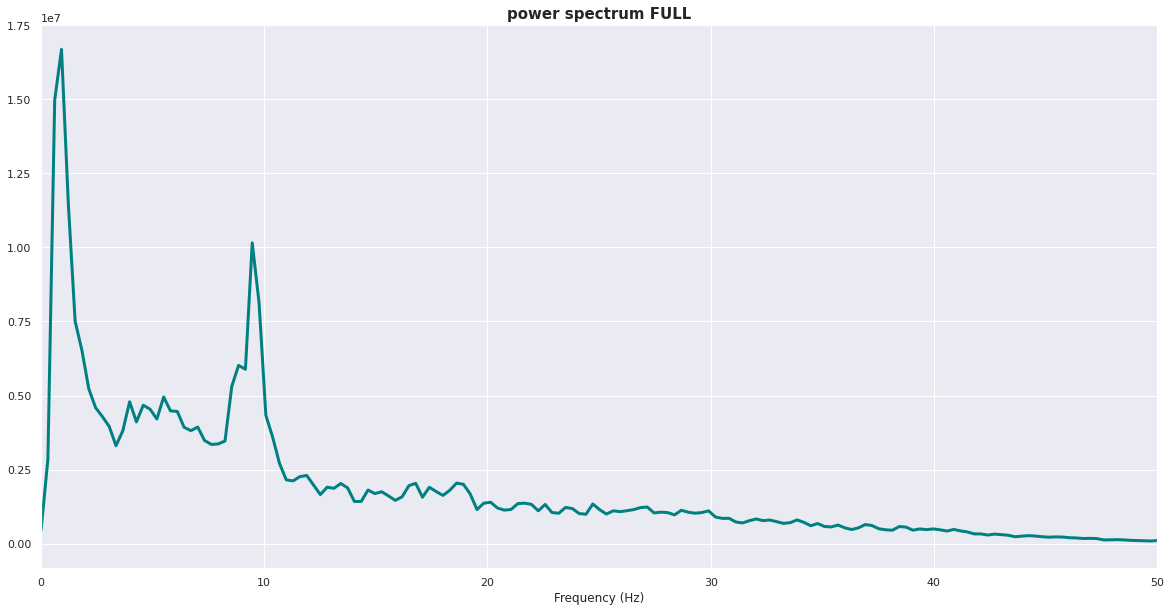

In [277]:
# Calculate and plot, for a single epoch of one subject, the full powerspectrum...
cal_power_spectrum(file, fs=fs, plot_figure=True, title_plot='power spectrum FULL', save_powspec=False)

##### ...but it's much more interesting to look at the powerspectrum of occipital vs non-occipital regions. 
alpha, yada yada

Specify which regions are occipital and which are non-occipital, and then we'll calculate powerspectrum for both.

In [269]:
occ_rois = np.arange(188,210) # Change this variable according to the atlas you used
nonocc_rois = np.arange(188) # Change this variable according to the atlas you used

f_occ, pxx_occ = cal_power_spectrum(file, fs=fs, nr_rois=occ_rois)
f_nonocc, pxx_nonocc = cal_power_spectrum(file, fs=fs, nr_rois=nonocc_rois)

##### And now we can make the plot. If all is well, the red powerspectrum should show a much higher peak around 8-12Hz (the alpha band) in the occipital compared to the non-occipital plots!

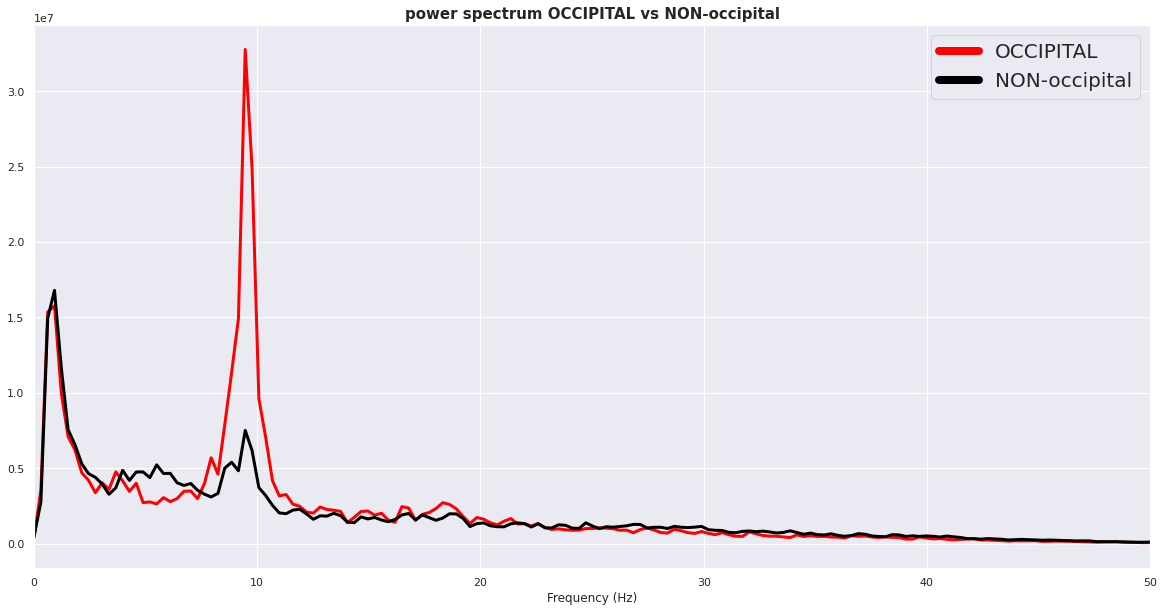

In [476]:
### --- see if we can add annotation to the lines themselves to point out occipital vs non-occipital
plt.figure(figsize=(20, 10))
plt.plot(f_occ, np.mean(pxx_occ,1), color='red', linewidth=3, label='OCCIPITAL')
plt.plot(f_nonocc, np.mean(pxx_nonocc, 1), color='black', linewidth=3, label='NON-occipital')
# add legend
leg = plt.legend(prop={'size': 20})
for line in leg.get_lines():
    line.set_linewidth(8)
#plt.plot(f, np.mean(pxx,1)+np.std(pxx,1), color='teal', linewidth=0.7)
#plt.plot(f, np.mean(pxx,1)-np.std(pxx,1), color='teal', linewidth=0.7)
#plt.fill_between(f, np.mean(pxx,1)+np.std(pxx,1), np.mean(pxx,1)
#                 -np.std(pxx,1), color='teal', alpha=0.2)
plt.xlim(0, 50)
plt.xlabel('Frequency (Hz)')
plt.title('power spectrum OCCIPITAL vs NON-occipital', size=15, weight='bold')
plt.show()

If all is well, you should see a much higher peak around 8-12Hz (the alpha band) in the occipital compared to the non-occipital (and full powerspectrum) plot(s)!

In [ ]:
### --- add same plots for all epochs of one subject and all epochs of all subjects (grand average)

<a id='fft-pli'></a>
## **4.** Fast fourier transform & the phase lag index (PLI)
#### Next, we'll filter the data into frequency bands and calculate functional connectivity.

In [ ]:
### fft_filt
function f = fft_filt(timeseries, Fs,thres1, thres2, nr_rois)
 
% This function filters timeseries between the given frequency
% bands (thres1 and thres2)
 
roi = 1:nr_rois;
f = zeros(numel(timeseries(:,1)), numel(roi));
abs_power = zeros(numel(roi));
power_05_30 = zeros(numel(roi));
rel_power = zeros(numel(roi));
 
freq = 1/length(timeseries):Fs/length(timeseries):Fs;
% include only freq. band of interest
[~, inx_thr1] = min(abs(freq-thres1));
[~, inx_thr2] = min(abs(freq-thres2));
        
for roi = 1:nr_rois
    xdft = fft(timeseries(:,roi));
%     abs_power(roi) = sum(abs(xdft(inx_thr1:inx_thr2)));
%     power_05_30(roi) = sum(abs(xdft(8:395)));
%     rel_power(roi) = abs_power(roi)/power_05_30(roi);
               
    % remove all other frequencies
    xdft(1:inx_thr1) = 0;
    xdft(inx_thr2:length(xdft)-inx_thr2) = 0;
    xdft(length(xdft)-inx_thr1:length(xdft)) = 0;               
              
    f(:,roi)= real(ifft2(xdft, 'symmetric'));
end
 
end

In [ ]:
#### pli_matteo
function m=pli_matteo(a)
% a is a filtered multichannel signal (time x channels)
% hilbert(a) calculates analytic signal (complex valued) of each
% column of a. Phase Lag Index between channel i and j averaged over
% time bins is stored in m(i,j)
% number of channels
N=size(a,2);
nch=size(a,2);
m(1:N,1:N)=0;
complex_a=hilbert(a);
for i=1:nch
    for j=1:nch
        if i<j
           
            %idx=aux<0.01
            %aux(idx)=0;
            %aux=floor(aux);
            m(i,j)=abs( mean (sign( (imag(complex_a(:,i)./complex_a(:,j)) ) ) ) ) ;
        
        end
    end
end
m=m+m';

In [10]:
def fft_filt(timeseries, thres1, thres2, fs=1250, nr_rois=np.arange(210)):
    
    """ Filter timeseries between the given frequency bands (thres1 and thres2)
    
    Parameters
    ----------
    timeseries: DataFrame with ndarrays
        Rows are timepoints, columns are rois/electrodes
    fs: int, optional
        Sample frequency, default=1250
    thres1: float
        Lower bound of frequency range data should be filtered between
    thres2: float
        Upper bound of frequency range data should be filtered between
    nr_rois: int, optional
        List of rois to be included, default=np.arange(210)
        
    Returns
    -------
    f: ndarray
        Array with filtered timeseries
    
    """
    
    f = np.empty([timeseries.shape[0], nr_rois.shape[0]])
    
    freq = np.arange(1/timeseries.shape[0], fs, fs/timeseries.shape[0])
    # include only frequency band of interest
    val, inx_thr1 = min((val, inx_thr1) for (inx_thr1, val) in enumerate(np.abs(freq - thres1)))
    val, inx_thr2 = min((val, inx_thr2) for (inx_thr2, val) in enumerate(np.abs(freq - thres2)))
    
    for roi in nr_rois:
        xdft = fft(timeseries[roi])
        
        # remove all other frequencies
        xdft[0:inx_thr1+1] = 0
        xdft[inx_thr2:xdft.shape[0]-inx_thr2-1] = 0
        xdft[xdft.shape[0]-(inx_thr1+1)-1:xdft.shape[0]] = 0
        
        f[:, roi] = irfft(xdft[0:int(len(xdft)/2+1)])
        
    return f

In [11]:
def pli_matteo(filtered_timeseries):
    
    """ Calculate the phase lag index (ref) between all pairs of regions
    
    Parameters
    ----------
    filtered_timeseries: ndarray 
        Rows are timepoints, columns are rois/electrodes
    
    Returns
    -------
    m: ndarray
        Array with PLI between channel i and j averaged over timebins
        
    """
    
    N = nch = filtered_timeseries.shape[1]
    m = np.zeros([N, N])
    
    complex_a = signal.hilbert(filtered_timeseries, axis=0)
    
    for i in np.arange(nch):
        for j in np.arange(nch):
            if i < j:
                m[i, j] = abs(np.mean(np.sign(((complex_a[:, i]/complex_a[:, j]).imag))))
                
    m = m + np.transpose(m)
    return m

In [24]:
# Compute PLI in upper alpha band for first epoch piece (4096 samples)
file_epoch = file[:4096]
matrix_alpha2 = pli_matteo(fft_filt(file_epoch, 10, 13))

# And set the diagonal to NaN so as not to show up in the plot
matrix_alpha2_diagNaN = matrix_alpha2.copy()
np.fill_diagonal(matrix_alpha2_diagNaN, np.nan)

In [360]:
# Compute PLI of whole first epoch - so epoch pieces and then average
nperseg = 4096 # samples per epoch to compute PLI over
nr_rois = 210 # number of atlas regions to be used

epoch_length = np.arange(0, file.shape[0], nperseg)
temp_alpha2 = np.zeros((len(epoch_length), nr_rois, nr_rois)) # initialize output array
for temp in np.arange(len(epoch_length)):
    temp_mat = file[epoch_length[temp]:epoch_length[temp]+nperseg]
    temp_alpha2[temp,:,:] = pli_matteo(fft_filt(temp_mat, 10, 13))

In [362]:
# Compute average of 4 epoch segments
mean_alpha2 = np.mean(temp_alpha2, axis=0)

# And set the diagonal to NaN so as not to show up in the plot
mean_alpha2_diagNaN = mean_alpha2.copy()
np.fill_diagonal(mean_alpha2_diagNaN, np.nan)

<a id='data-check-2'></a>
## **5.** Checking the data - II
<a id='adjacency-matrix'></a>
### a. Adjacency matrices

Text(0.5, 1.0, 'PLI adjacency matrix - alpha2')

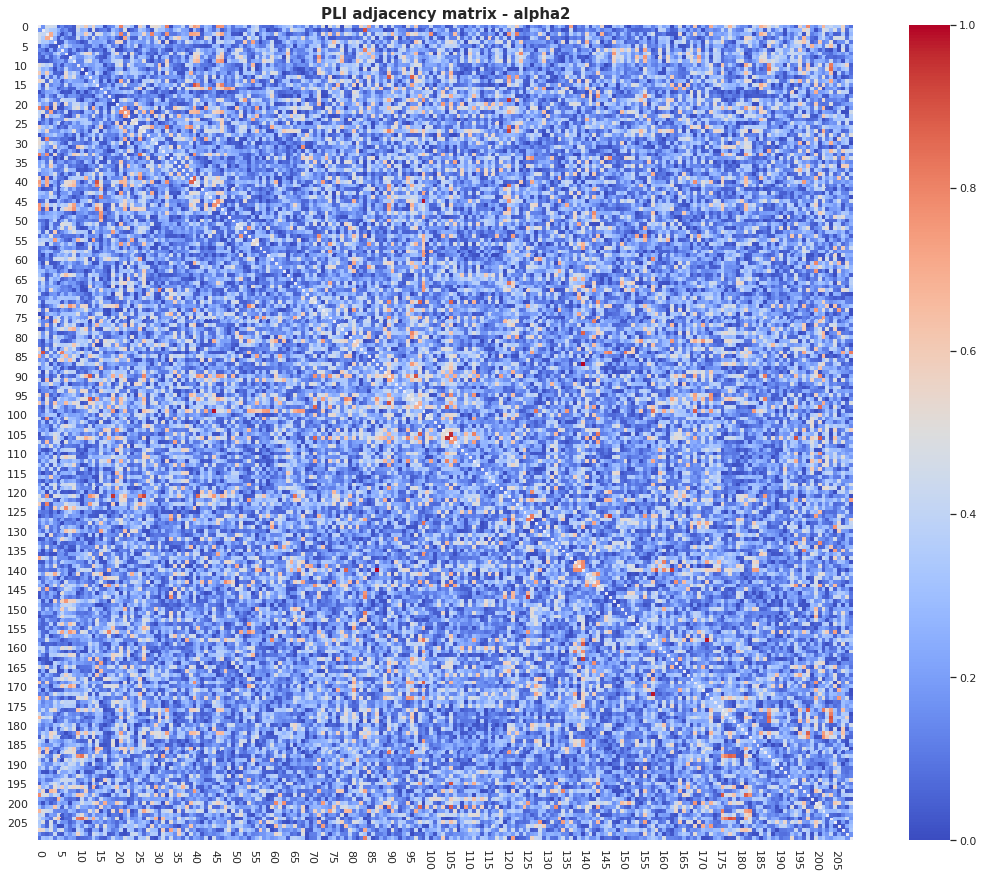

In [28]:
# Plot the correlation matrix of one epoch segment
plt.figure(figsize = (20, 15))
plt.xticks(rotation=270)
_ = sns.heatmap(matrix_alpha2_diagNaN, cmap='coolwarm', cbar=True, square=True, mask=False, 
                xticklabels=5, yticklabels=5)
_.set_title('PLI adjacency matrix - alpha2', size=15, fontweight='bold')

Text(0.5, 1.0, 'PLI adjacency matrix - alpha2')

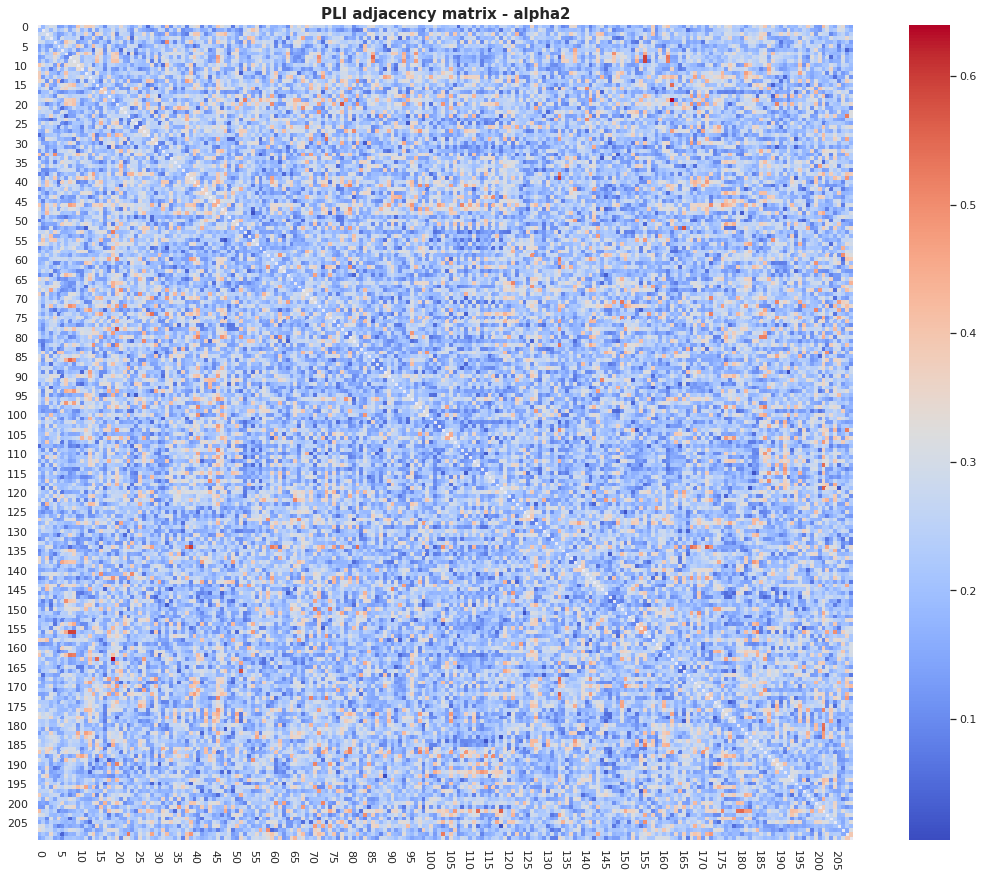

In [363]:
# Plot the average correlation matrix of one epoch (multiple segments)
plt.figure(figsize = (20, 15))
plt.xticks(rotation=270)
_ = sns.heatmap(mean_alpha2_diagNaN, cmap='coolwarm', cbar=True, square=True, mask=False, 
                xticklabels=5, yticklabels=5)
_.set_title('PLI adjacency matrix - alpha2', size=15, fontweight='bold')

<a id='check-signal'></a>
### b. Check for empty or weird signals

In [364]:
# Checking if there are NaNs, infs, zeros in the mean matrix
print('Matrix has Infs: ' + str(np.isinf(mean_alpha2).any()))
print('Matrix has NaNs: ' + str(np.isnan(mean_alpha2).any()))
print('Matrix has Zeros: ' + str((mean_alpha2_diagNaN == 0).any()))
### Not sure how informative this is - is it even weird for PLI to be 0 occasionally?
### maybe also remember this; these plots are probably more informative when PLI is 
### averaged over multiple epochs

Matrix has Infs: False
Matrix has NaNs: False
Matrix has Zeros: False


/home/kingwizard/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:194: RuntimeWarning:

All-NaN slice encountered

/home/kingwizard/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:199: RuntimeWarning:

All-NaN slice encountered



Text(0.5, 1.0, 'PLI adjacency matrix - mean alpha2')

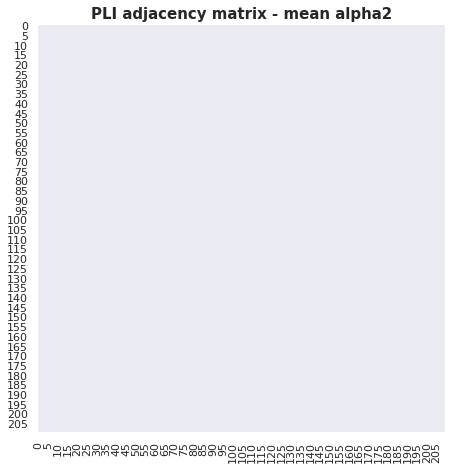

In [411]:
# Plot the correlation matrix with ONLY THE 0s!
cmap1 = mpl.colors.ListedColormap(['r'])

plt.figure(figsize = (10, 7.5))
plt.xticks(rotation=270)
_ = sns.heatmap(mean_alpha2_diagNaN, mask=mean_alpha2_diagNaN!=0, cmap=cmap1, cbar=False,
                square=True, xticklabels=5, yticklabels=5)
_.set_title('PLI adjacency matrix - mean alpha2', size=15, fontweight='bold')

In [29]:
# Checking if there are NaNs, infs, zeros.
print('Matrix has Infs: ' + str(np.isinf(matrix_alpha2).any()))
print('Matrix has NaNs: ' + str(np.isnan(matrix_alpha2).any()))
print('Matrix has Zeros: ' + str((matrix_alpha2 == 0).any()))
### Not sure how informative this is - is it even weird for PLI to be 0 occasionally?
### maybe also remember this; these plots are probably more informative when PLI is 
### averaged over multiple epochs

Matrix has Infs: False
Matrix has NaNs: False
Matrix has Zeros: True


Text(0.5, 1.0, 'PLI adjacency matrix - alpha2')

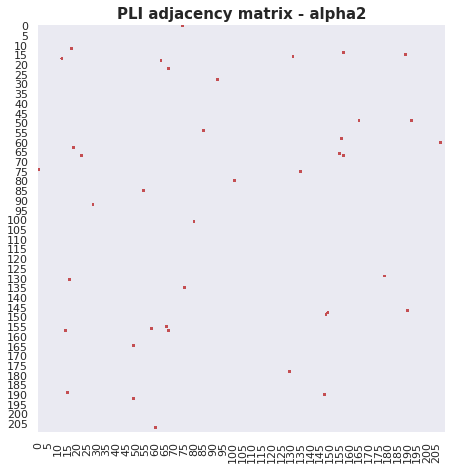

In [412]:
# Plot the correlation matrix with ONLY THE 0s!
cmap1 = mpl.colors.ListedColormap(['r'])

plt.figure(figsize = (10, 7.5))
plt.xticks(rotation=270)
_ = sns.heatmap(matrix_alpha2_diagNaN, mask=matrix_alpha2_diagNaN!=0, cmap=cmap1, cbar=False,
                square=True, xticklabels=5, yticklabels=5)
_.set_title('PLI adjacency matrix - alpha2', size=15, fontweight='bold')

In [66]:
print(np.where(matrix_alpha2_diagNaN == 0)[0])
print(np.where(matrix_alpha2_diagNaN == 0))

[  0  12  14  15  16  17  18  22  28  49  49  54  58  60  63  66  67  67
  74  75  80  85  92 101 129 131 135 147 148 149 155 156 157 157 165 178
 189 190 192 207]
(array([  0,  12,  14,  15,  16,  17,  18,  22,  28,  49,  49,  54,  58,
        60,  63,  66,  67,  67,  74,  75,  80,  85,  92, 101, 129, 131,
       135, 147, 148, 149, 155, 156, 157, 157, 165, 178, 189, 190, 192,
       207]), array([ 74,  17, 157, 189, 131,  12,  63,  67,  92, 165, 192,  85, 156,
       207,  18, 155,  22, 157,   0, 135, 101,  54,  28,  80, 178,  16,
        75, 190, 149, 148,  66,  58,  14,  67,  49, 129,  15, 147,  49,
        60]))


In [68]:
idx_i = np.where(matrix_alpha2_diagNaN == 0)[0]
idx_j = np.where(matrix_alpha2_diagNaN == 0)[1]
print(matrix_alpha2_diagNaN[idx_j, idx_i])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


<a id='occ-network'></a>
### c. The occipital network

In [455]:
# Specify nodes belonging to the occipital network -- remember Python indexing starts with 0
yeo_occ = np.concatenate([[105, 106, 108, 114, 119, 120, 135, 152], np.arange(189,211)])
yeo_occ

array([105, 106, 108, 114, 119, 120, 135, 152, 189, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206,
       207, 208, 209, 210])

<a id='aec'></a>
## **?** The amplitude envelope correlation (AEC)
#### Additionally, we'll compute another measure of functional connectivity: the AEC.

In [456]:
import numpy as np 
#from numpy import fft
from scipy.signal import hilbert
from scipy.fft import fft, irfft2, ifft2, irfftn, irfft, ifft
import scipy
import statsmodels.api as sm
import math

from tqdm import tqdm

In [477]:
import numpy as np 
from numpy import fft
from scipy.signal import hilbert
from scipy import fft
import scipy
import statsmodels.api as sm
import pandas as pd
import os
from tqdm import tqdm

In [420]:
def smooth(a, WSZ):
    
    """ Smoothing function 
    Smoothes the input array using a moving average filter
    
    Parameters
    ----------
    a: ndarray 
        Array containing the data to be smoothed
    WSZ: int 
        Smoothing window size (must be odd)
    
    Returns
    -------
    smoothed: ndarray 
        Array containing the smoothed input data 
    
    Notes
    -----
    Reference: https://stackoverflow.com/a/40443565    
    """
    
    if WSZ % 2 == 0:
        WSZ -= 1
    
    out0 = np.convolve(a,np.ones(WSZ,dtype=int),'valid')/WSZ    
    r = np.arange(1,WSZ-1,2)
    start = np.cumsum(a[:WSZ-1])[::2]/r
    stop = (np.cumsum(a[:-WSZ:-1])[::2]/r)[::-1]
    smoothed = np.concatenate((  start , out0, stop  ))
    
    return smoothed

In [459]:
def envelopecorr(data, sm_param):
    
    """ Function to calculate amplitude envelope correlations
    
    Calculate the amplitude envelope correlation with pairwise 
    leakage correction as a measure of functional connectivity
    
    Parameters
    ----------
    data: ndarray
        Array containing filtered timeseries,
        rows are timpoints, columns are rois/electrodes 
    sm_param: int
        Smoothing window size (must be odd)
    verbose: bool, optional
        If true, progress is printed to console, default=False    
    
    Returns
    ------
    ENV_corr: nxn array of amplitude envelope correlations
    
    """
 
    ENV_corr = np.zeros((data.shape[1], data.shape[1]))
    for i in tqdm(range(0,data.shape[1])):
            
            x = data[:, i]
            htx = hilbert(x)
            htx = smooth(htx, sm_param)
            envelope_x = np.sqrt((np.power(np.real(htx),2) + np.power(np.imag(htx),2)))
            
            for j in range(0, data.shape[1]):
                if i != j:
                    y = data[:,j]
                    
                    #Regression
                    model = sm.OLS(y, x).fit()
                    #coeffs = model.params
                    #conf_inter = model.conf_int
                    resids = model.resid
                    
                    #step 1: compute the hilbert transform and bring it to the origin
                    hty = hilbert(resids)
                    hty = smooth(hty, sm_param)
                   
                    #step 2: compute envelope data
                    envelope_y = np.sqrt((np.power(np.real(hty),2) + 		np.power(np.imag(hty),2)))
                    
                    #correlation between envelopes 
                    ENV_corr[i,j] = np.corrcoef(envelope_x, envelope_y)[0,1]
        
    ENV_corr2 = (ENV_corr + ENV_corr.conj().T)/2
        
    return(ENV_corr2)

In [478]:
def get_data(filepath, sub, nr_epochs, nr_rois):
    """Function to get MEG data. 
    Extract all epochs of MEG data for the current subject. 
    
    Parameters
    ----------
    filepath: str, 
                path to directory in which MEG data is stored.
    
    sub: str,
            subject for which MEG data should be extracted e.g. 'sub_01'
    
    nr_epoch: int,
              number of epochs to extract per subject
              
    nr_rois: int,
             number of rois to be included in analysis
    
    Output
    ------
    all_epochs: pd.DataFrame, 
                contains the epochs of MEG data (for every roi) for the current subjects 
              
    """

        
    #get all files of subject that are in MEG directory of subject
    path = os.path.join(filepath, sub) 
    files = [file for file in sorted(os.listdir(path))]
        
    all_epochs = []    
    for j in range(0, nr_epochs): 
            
        #load every epoch (file) in directory of current subject and store in list  
        current_epoch = pd.read_table(os.path.join(path, files[j]), header = None)
        all_epochs.append(current_epoch)
        
    #concatenate epochs in pd.DataFrame
    all_epochs = pd.concat(all_epochs)   
    
    return(all_epochs)

In [479]:
# Parameters:
sample_freq = 1250
f_low = 10 
f_high = 13 
nr_rois = 210
sm_param = math.floor(sample_freq * 0.25)
nr_epochs = 4

In [486]:
filepath = '/home/kingwizard/mumo_projects/meg_datacheck/meg_data/'
subs = ['sub_01']
for i, sub in enumerate(subs):
    print(sub)

sub_01


In [487]:
# Loop through subjects:
AEC = np.zeros((nr_rois, nr_rois, len(subs)))

for i, sub in enumerate(subs):
    
    #1.) extract and concatenate all timeseries for subject i 
    timeseries = get_data(filepath, sub, nr_epochs, nr_rois)
    
    #2.) filter the data into frequency band
    data_filt = fft_filt(timeseries, f_low, f_high, sample_freq, np.arange(0,nr_rois))
    
    #3.) calculate and store amplitude envelope correlations 
    AEC[:, : , i] = envelopecorr(data_filt, sm_param)

/home/kingwizard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning:

Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.

100%|██████████| 210/210 [21:24<00:00,  6.12s/it]


In [498]:
### --- (AECc + 1)/2 to correct for negative values? -> this is clearly not in the function as seen by the
### adjacency matrix; but Shanna mentioned this in her presentation (@knw 21.02.26) -- and i think in an
### earlier email conversation as well, !!!LOOK THIS UP!!!

# Correct for negative values
aec_alpha2_corr = AEC[:, :, 0].copy()
aec_alpha2_corr = (aec_alpha2_corr + 1)/2

# Set diagonal to NaN
np.fill_diagonal(aec_alpha2_corr, np.nan)

In [490]:
# Set the diagonal to NaN so as not to show up in the plot
aec_alpha2_diagNaN = AEC[:, :, 0].copy()
np.fill_diagonal(aec_alpha2_diagNaN, np.nan)

Text(0.5, 1.0, 'AEC adjacency matrix - alpha2')

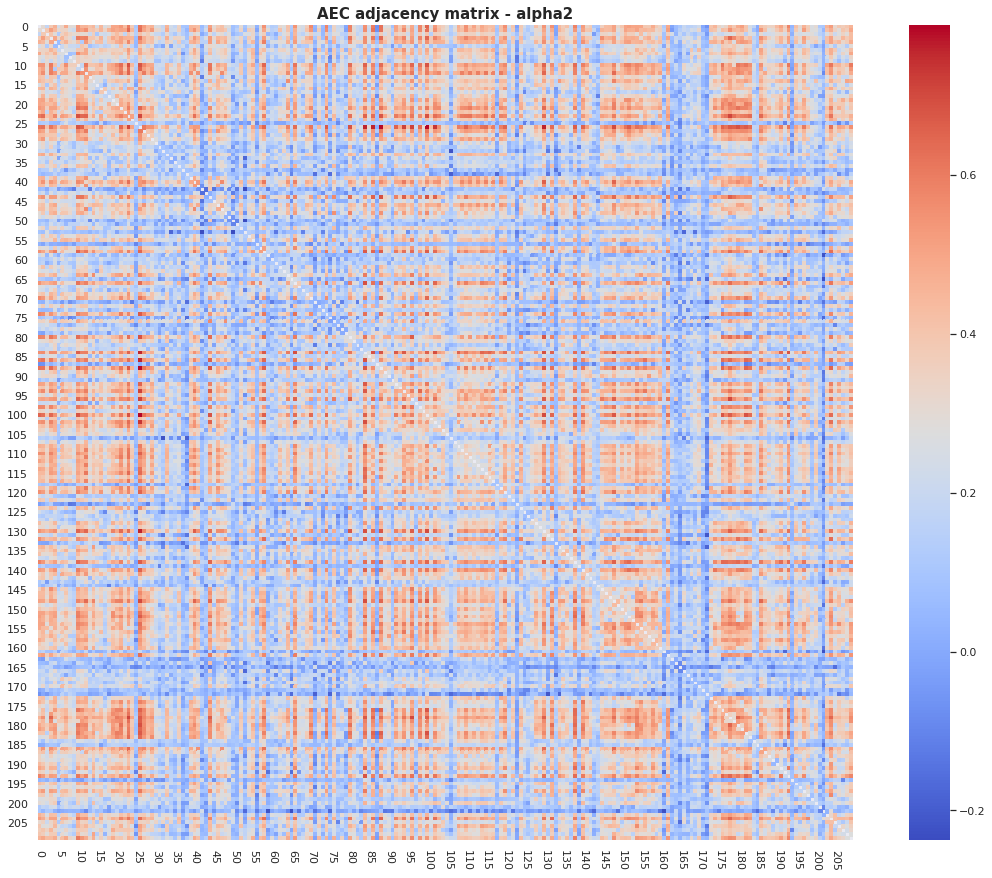

In [491]:
# Plot AEC correlation matrix of one subject
plt.figure(figsize = (20, 15))
plt.xticks(rotation=270)
_ = sns.heatmap(aec_alpha2_diagNaN, cmap='coolwarm', cbar=True, square=True, mask=False, 
                xticklabels=5, yticklabels=5)
_.set_title('AEC adjacency matrix - alpha2', size=15, fontweight='bold')

Text(0.5, 1.0, 'AEC adjacency matrix - alpha2; CORRECTED FOR NEGATIVE VALUES?')

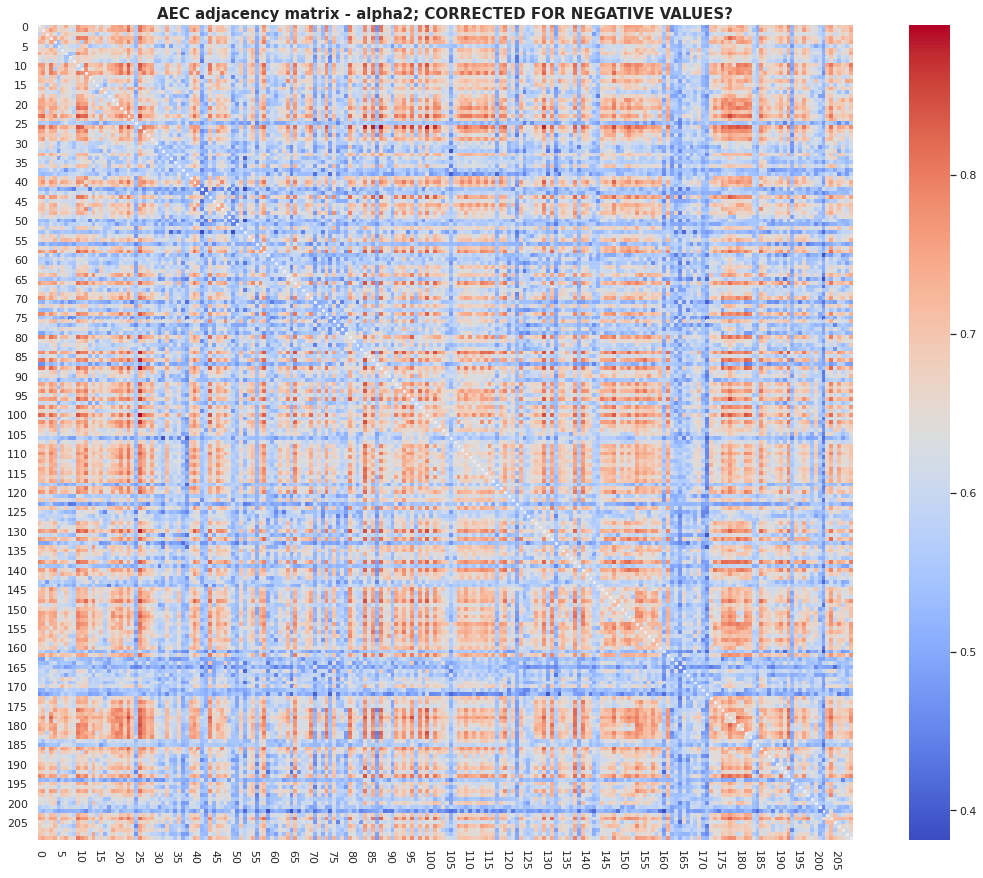

In [500]:
# Plot AEC correlation matrix of one subject
plt.figure(figsize = (20, 15))
plt.xticks(rotation=270)
_ = sns.heatmap(aec_alpha2_corr, cmap='coolwarm', cbar=True, square=True, mask=False, 
                xticklabels=5, yticklabels=5)
_.set_title('AEC adjacency matrix - alpha2; CORRECTED FOR NEGATIVE VALUES?', size=15, fontweight='bold')